# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Finding Lane Lines on the Road** 
***
This project focused on lane finding from a dashboard mounted camera. First, an image analysis pipeline is developed using a series of individual images, and then applied a video stream to assess the performance of lane finding with an environment with curved road features.

### Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob
import pickle

%matplotlib inline

### Read in example image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


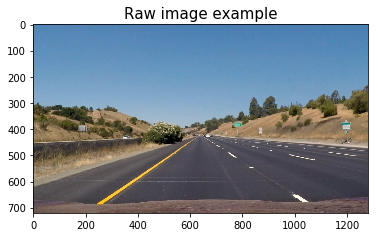

In [4]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.title('Raw image example', fontsize=15)
plt.imshow(image)

### Camera Calibration
***
First, the ChessBoard calibration images are read into a function and cv2 functions are used to identify the corners within the ChessBoard calibration images. The calibration information is then saved as a calibration file which can be used later when applying distortion correction.

In [5]:
# Define a set of object points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Define arrays to store object (3D space) and image (2D space) points from imported images
objpoints = []
imgpoints = []

# print a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Iterate through the list, searching for chesseboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use cv2 to find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        print('working on ', fname)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw the found corners, save images to the output_images folder
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found' + str(idx) + '.jpg'
        cv2.imwrite('./output_images/chessboard_images/' + write_name, img)
        
# Load image for reference
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Perform camera calibration for the given object and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the calibration file
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))

working on  ./camera_cal\calibration10.jpg
working on  ./camera_cal\calibration11.jpg
working on  ./camera_cal\calibration12.jpg
working on  ./camera_cal\calibration13.jpg
working on  ./camera_cal\calibration14.jpg
working on  ./camera_cal\calibration15.jpg
working on  ./camera_cal\calibration16.jpg
working on  ./camera_cal\calibration17.jpg
working on  ./camera_cal\calibration18.jpg
working on  ./camera_cal\calibration19.jpg
working on  ./camera_cal\calibration2.jpg
working on  ./camera_cal\calibration20.jpg
working on  ./camera_cal\calibration3.jpg
working on  ./camera_cal\calibration6.jpg
working on  ./camera_cal\calibration7.jpg
working on  ./camera_cal\calibration8.jpg
working on  ./camera_cal\calibration9.jpg


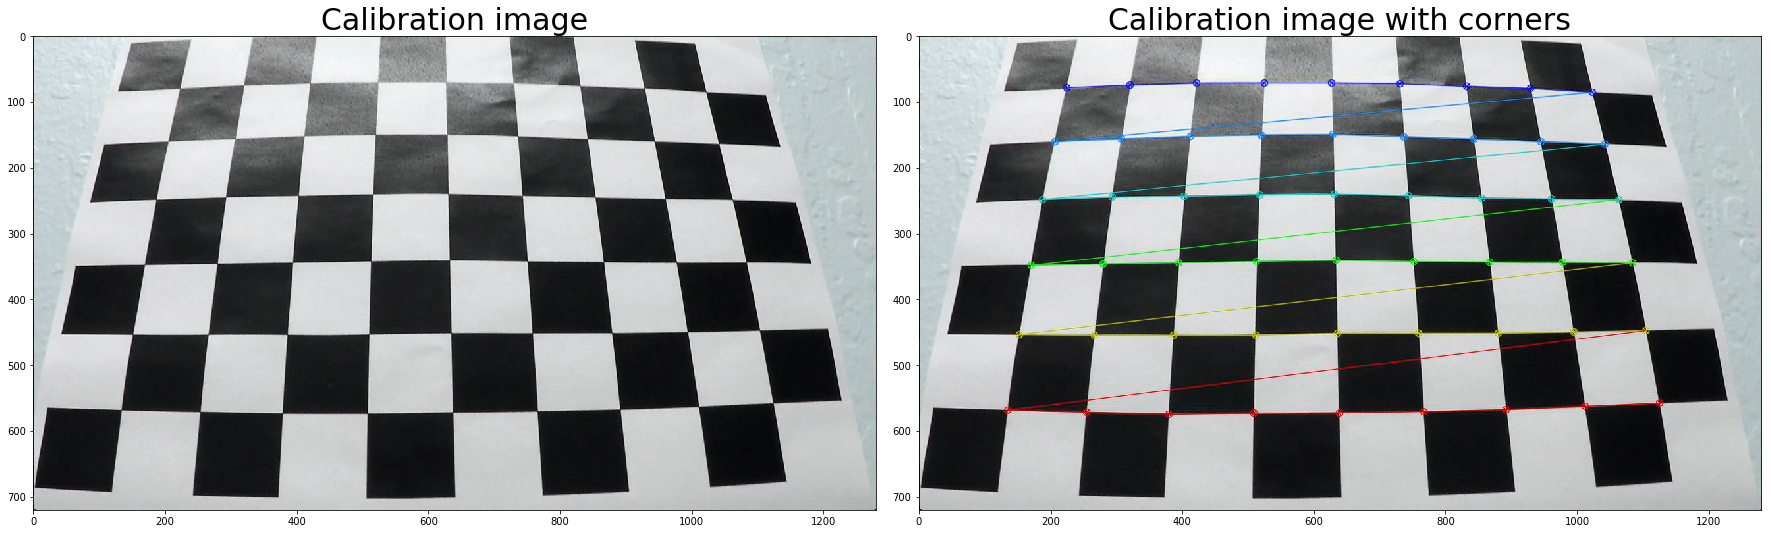

In [6]:
# Plot an example of the calibration image and after finding corners

cal_img_3 = cv2.imread('./camera_cal/calibration3.jpg')
foundlines_img_13 = cv2.imread('./output_images/chessboard_images/corners_found13.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_img_3)
ax1.set_title('Calibration image', fontsize=30)
ax2.imshow(foundlines_img_13, cmap='gray')
ax2.set_title('Calibration image with corners', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Define Undistortion Function
***
The camera calibration file is used to undistort the images.

In [29]:
# Read in the saved camera matrix and distortion coefficients

dist_pickle = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in a test image
img = cv2.imread('./camera_cal/calibration3.jpg')

# Define chessboard size parameters, nx (number of inside corners in x) and ny (number of inside corners in y)

nx = 9
ny = 6

def corners_unwarp(img, nx, ny, mtx, dist):
    
    # Undistort using mtx and dist
    img_size = (img.shape[1], img.shape[0])
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # Darw corners if corners are found
    if ret == True:
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        # Define 4 source points src = np.float32([[,],[,],[,],[,]])
        # Detected corners found using the automatic corner detection
        offset = 100
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            
        # Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset],[img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]])
            
        # Use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
            
        # Use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size)
    
    return warped, M

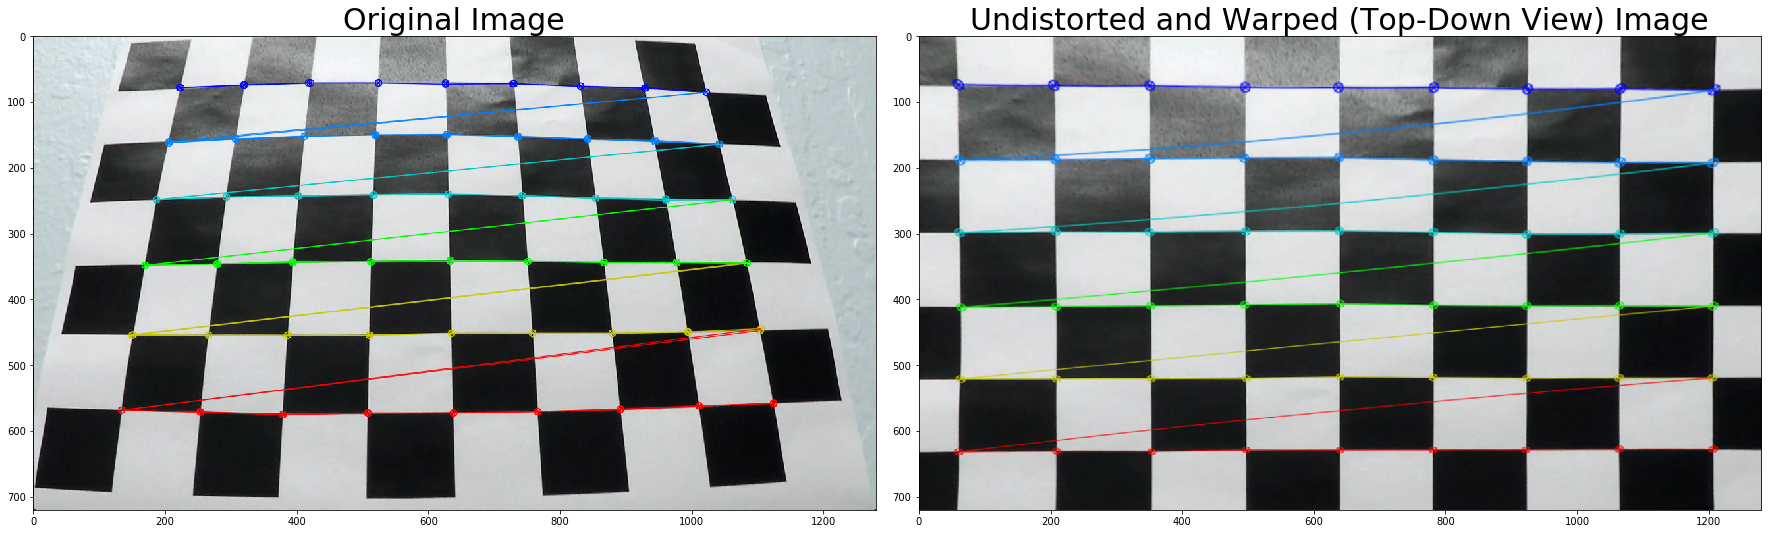

In [31]:
# Test the undistort and warp function

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped (Top-Down View) Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Sobel Functions
***
Define the Sobel threshold transformation function.

In [9]:
# Define the Absolute Sobel Threshold Function that applies Sobel x or y, and then takes an absolute value and applies a threshold.

def abs_sobel_thresh(img, orient='x', sobel_kernel = 5, thresh = (0, 255)):
    #def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # Take the absolute value of the derivative or gradient
    
    if orient == 'x':
        abs_sobel = np.absolute(sobelx)
    
    if orient == 'y':
        abs_sobel = np.absolute(sobely)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

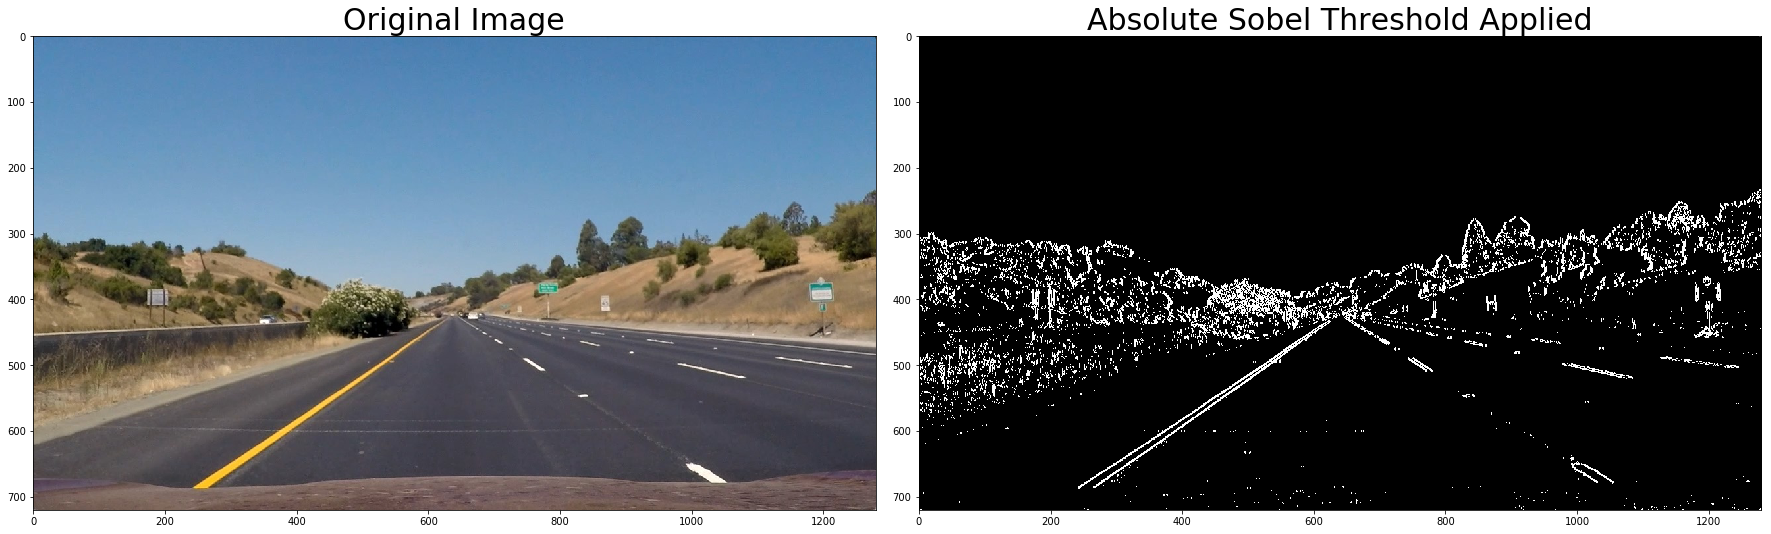

In [10]:
# Test the abs_sobel_thresh function
# Read in a test image and grayscale it
image = mpimg.imread('test_images/straight_lines1.jpg')
    
# Run the function to test
grad_binary = abs_sobel_thresh(image, orient='x', thresh = (20, 250))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Absolute Sobel Threshold Applied', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
# Define and test the Magnitude Sobel Threshold Function.

def mag_thresh(image, sobel_kernel = 3, mag_thresh = (0, 255)):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag < mag_thresh[1])] = 1
    
    return binary_output

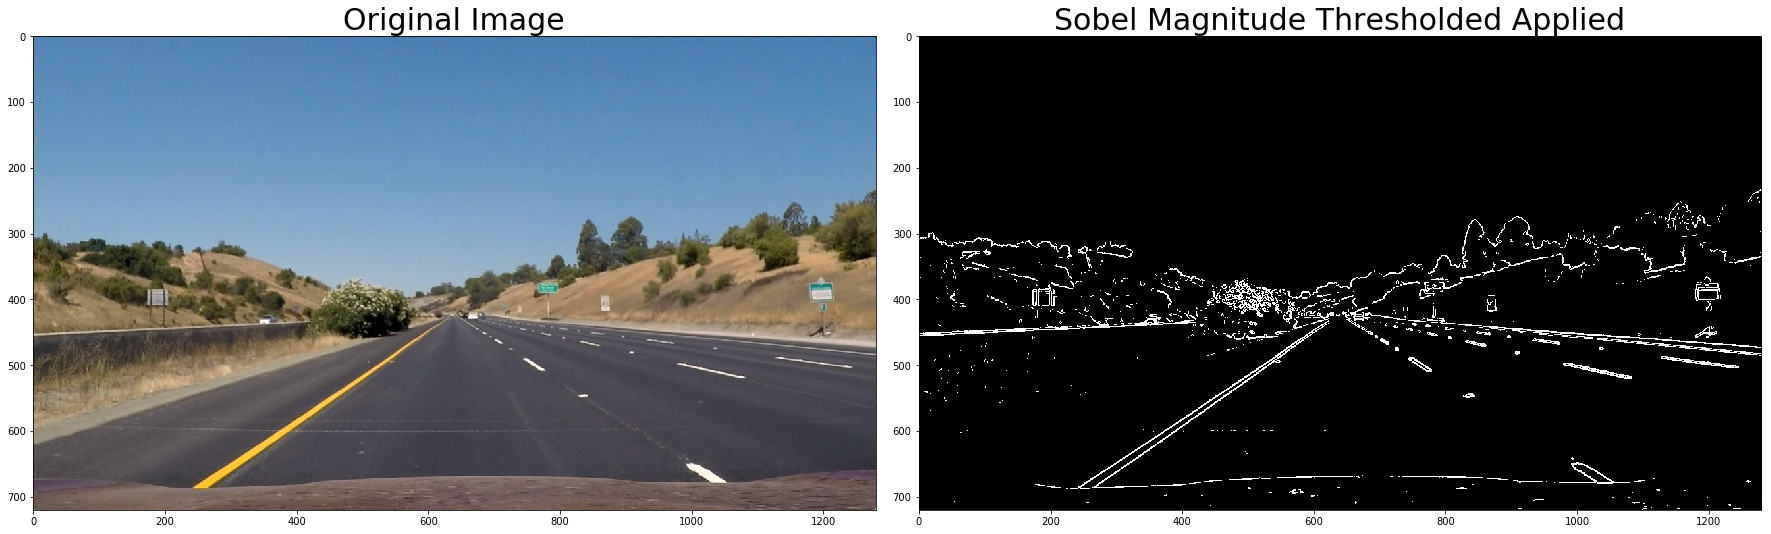

In [12]:
# Test the mag_thresh function
# Read in a test image

image = mpimg.imread('test_images/straight_lines1.jpg')
    
# Run the function to test
mag_thresh_test = mag_thresh(image, sobel_kernel = 3, mag_thresh = (50, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(mag_thresh_test, cmap='gray')
ax2.set_title('Sobel Magnitude Thresholded Applied', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Filtering and Transformations
***
First, the ChessBoard calibration images are read into a function and cv2 functions are used to identify the corners within the ChessBoard calibration images. The calibration information is then saved as a calibration file which can be used later when applying distortion correction.

In [13]:
# Define HLS Color Threshold Function that thresholds the S-channel of HLS and test it.

def hls_select(img, thresh=(0, 255)):
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

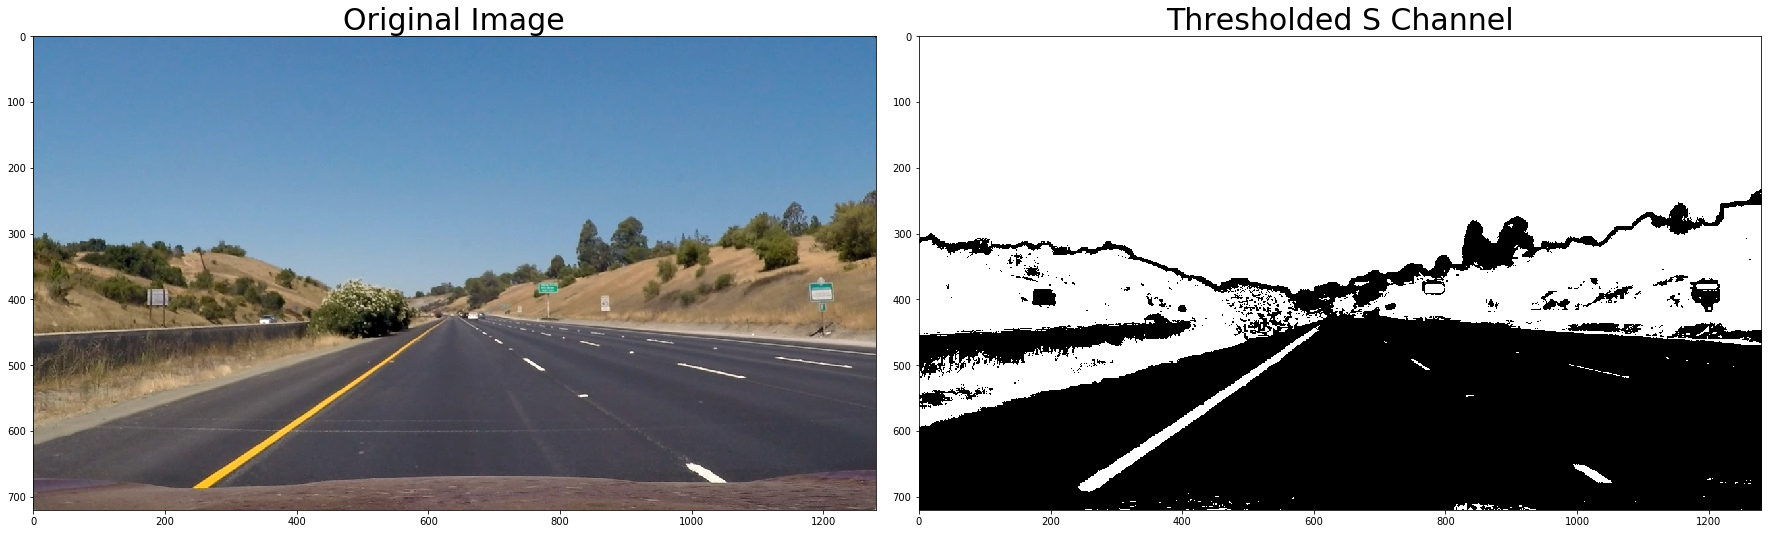

In [14]:
# Test the hls_select function

hls_binary = hls_select(image, thresh=(50, 255))

# Read in a test image
image = mpimg.imread('test_images/straight_lines1.jpg') 

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(hls_binary, cmap='gray')

ax2.set_title('Thresholded S Channel', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
# Define a color threshold function with HLS and HSV and test it.

def color_threshold(image, sthresh = (0,255), vthresh=(0,255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output

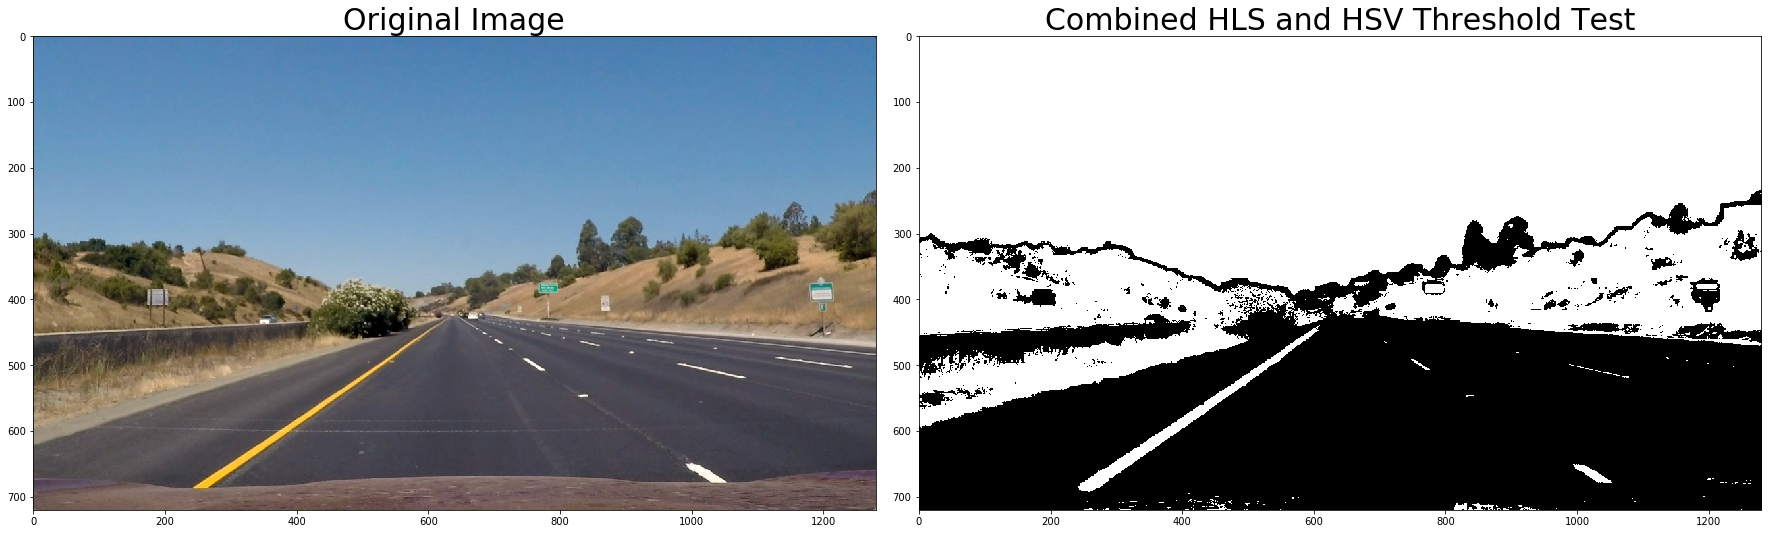

In [16]:
# Test the color_threshold function

# Read in a test image
image_test = mpimg.imread('test_images/straight_lines1.jpg')

thresh_test = color_threshold(image_test, sthresh = (50,255), vthresh = (50,255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_test)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(thresh_test, cmap='gray')
ax2.set_title('Combined HLS and HSV Threshold Test', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
def window_mask(width, height, img_ref, center, level):
    
    output = np.zeros(img_ref)
    output[int(img_ref.shape[0] (level*1)*height):int(img_ref.shape[0] + level*height), max(0, int(center + width))]
    
    return output

### Define Perspective Transform
***
...

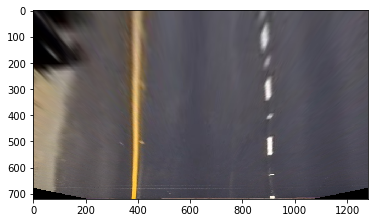

In [28]:
def perspective_transform(image):

    img_size = (img.shape[1], img.shape[0])

    preprocessImage = np.zeros_like(img[:,:,0])

    bot_width = 0.75 # percent of bottom trapizoid height
    mid_width = 0.08 # percent of middle trapizoid height
    height_pct = 0.62 # percent for trapizoid width
    bottom_trim = 0.95 # percent from top to bottom to avoid car hood

    src = np.float32([[img.shape[1] * (0.5 - mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + bot_width / 2), img.shape[0] * bottom_trim],
                      [img.shape[1] * (0.5 - bot_width / 2), img.shape[0] * bottom_trim]])

    offset = img_size[0] * 0.25

    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])

    # Define topdown perspective transform

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(image, M, img_size, flags = cv2.INTER_LINEAR)

    return warped

warp_test = perspective_transform(image)
plt.imshow(warp_test)

### Implement Sliding Windows Function
***
Define a funtion to slide an observation window across the image to detect the lane lines.

In [29]:
def sliding_window(binary_warped):

    # With the binary_warped image as an input,
    # a histogram of the bottom half of the image is caputred.
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img

In [30]:
sliding_test =  sliding_window(binary_warped)
    
plt.imshow(sliding_test)
plt.title('Sliding Window Example', fontsize=15)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

TypeError: expected non-empty vector for x

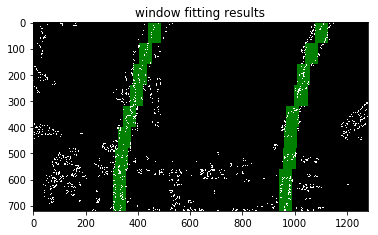

In [116]:
# Convolution approach to sliding window

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = mpimg.imread('examples/warped_example.jpg')

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [118]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

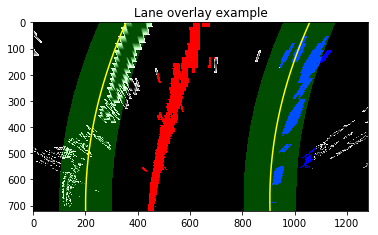

In [121]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.title('Lane overlay example')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Fit Polynomial to Point Clouds
***
First, the ChessBoard calibration images are read into a function and cv2 functions are used to identify the corners within the ChessBoard calibration images. The calibration information is then saved as a calibration file which can be used later when applying distortion correction.

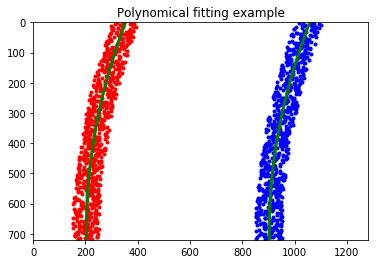

In [123]:
# Measure the found curve

import numpy as np
import matplotlib.pyplot as plt

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.title('Polynomical fitting example')
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Calculate radius of curvature of the found line



### Implement the Full Image Processing Pipeline
***
Using the camera calibration file, a function is created to undistort the images and video feed in order to improve the ability to characterize the curvature of the lane lines later in the pipeline.

In [104]:
# define a list of the test images
images = glob.glob('test_images/test*.jpg')

for idx, fname in enumerate(images):
    # read in image
    img = cv2.imread(fname)
    
    # undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # image processing
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient = 'x', thresh = (12,255))
    grady = abs_sobel_thresh(img, orient = 'y', thresh = (25,255))
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
    
    img_size = (img.shape[1], img.shape[0])
    
    bot_width = 0.76 # percent of bottom trapizoid height
    mid_width = 0.08 # percent of middle trapizoid height
    height_pct = 0.62 # percent for trapizoid width
    bottom_trim = 0.9 # percent from top to bottom to avoid car hood
    
    src = np.float32([[img.shape[1] * (0.5 - mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + bot_width / 2), img.shape[0] * bottom_trim],
                      [img.shape[1] * (0.5 - bot_width / 2), img.shape[0] * bottom_trim]])
    offset = img_size[0] * 0.25
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    
    # Define topdown perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(preprocessImage, M, img_size, flags = cv2.INTER_LINEAR)
    
    result = binary_warped
    
    # write the undistored images to disk
    write_name = './output_images/processed/' + str(idx) + '.jpg'
    cv2.imwrite(write_name, result)

### Video Analysis
***
First, the ChessBoard calibration images are read into a function and cv2 functions are used to identify the corners within the ChessBoard calibration images. The calibration information is then saved as a calibration file which can be used later when applying distortion correction.

In [ ]:
from moviepy.editor import VideoFlileClip
from IPython.display import HTML
import numpy as np
import cv2
import pickle
import glob
#from tracker import tracker

dist_pickle = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

Output_video = 'output1_tracked.mp4'
Input_video = 'project_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(Output_video, audio = False)



### ...
***
First, the ChessBoard calibration images are read into a function and cv2 functions are used to identify the corners within the ChessBoard calibration images. The calibration information is then saved as a calibration file which can be used later when applying distortion correction.